ConvBiLSTM and ConvBiGRU for Perth Data

Epoch 1/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6147 - mae: 0.6456
Epoch 1: val_loss improved from inf to 0.37240, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5997 - mae: 0.6352 - val_loss: 0.3724 - val_mae: 0.4707
Epoch 2/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2626 - mae: 0.3974
Epoch 2: val_loss improved from 0.37240 to 0.33671, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2624 - mae: 0.3972 - val_loss: 0.3367 - val_mae: 0.4390
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2534 - mae: 0.3949
Epoch 3: val_loss did not improve from 0.33671
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2532 - mae: 0.3947 - val_loss: 0.3401 - val_mae: 0.4489
Epoch 4/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2446 - mae: 0.3982
Epoch 4: val_loss improved from 0.33671 to 0.32638, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2442 - mae: 0.

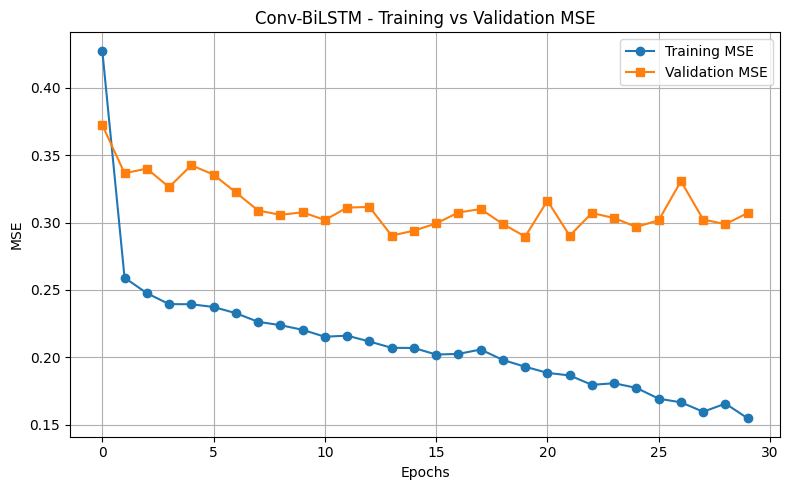

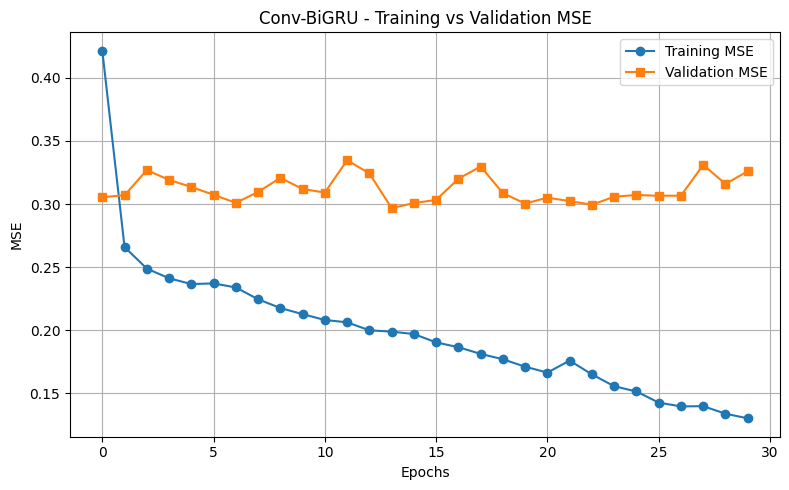

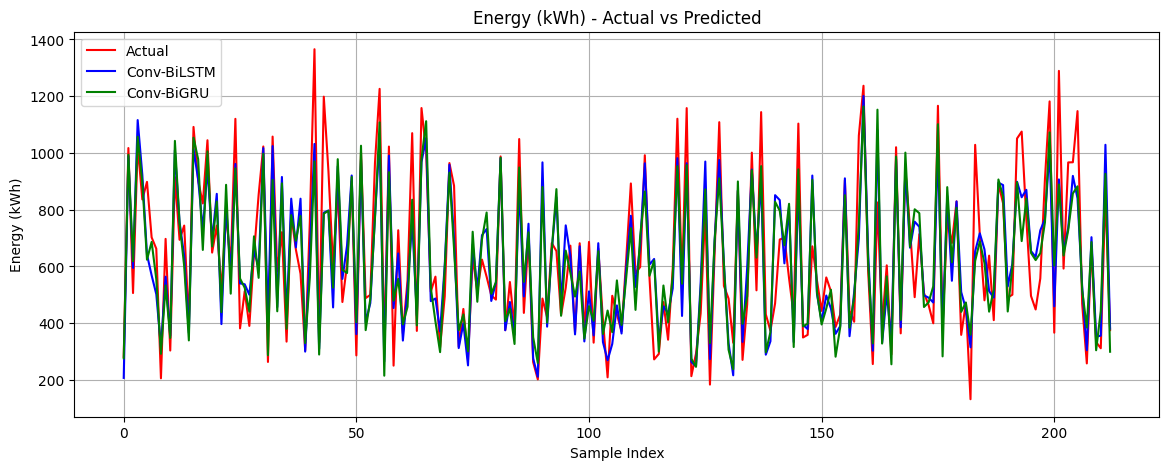

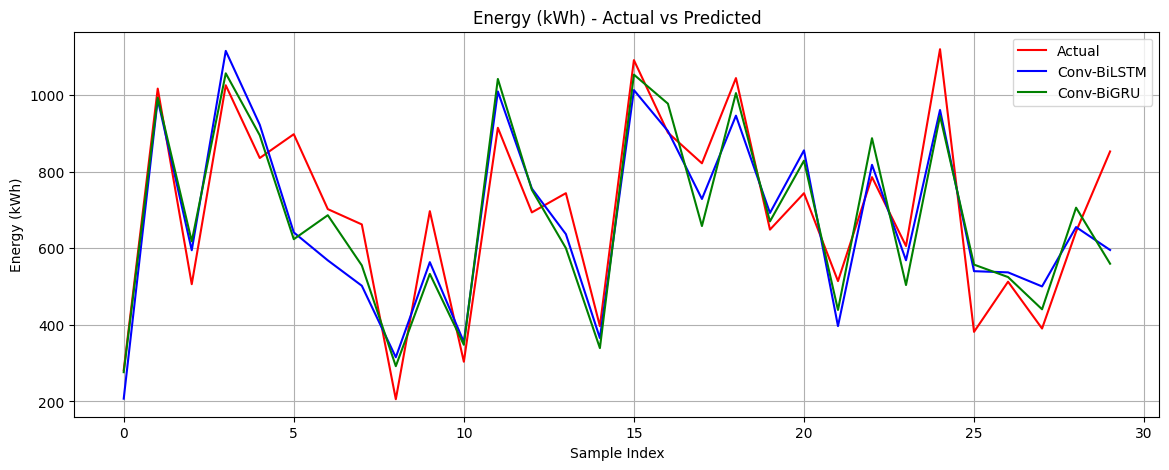

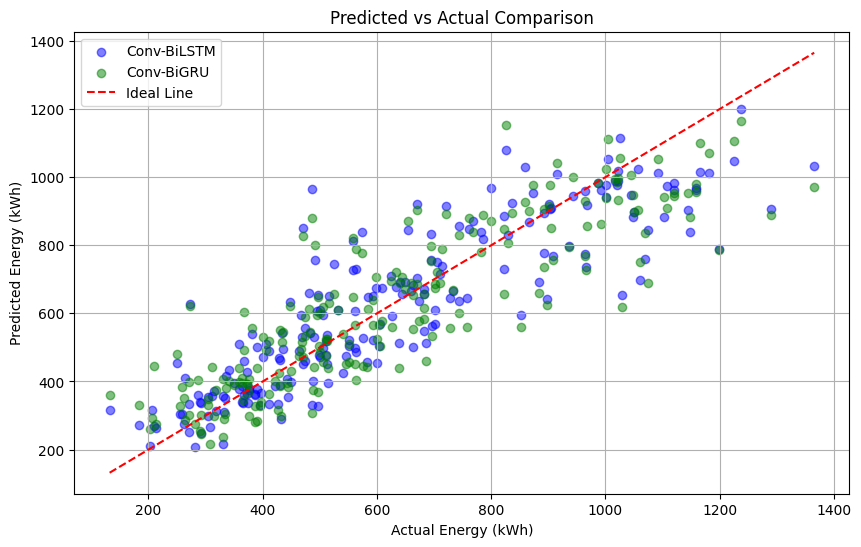

In [26]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
from math import sqrt

# Load dataset
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

# Define columns
categorical_cols = ['CP ID', 'Connector', 'Site', 'Model', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Total_time_hours']
target_col = 'Total kWh'

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Apply StandardScaler to numerical columns + target
scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Split into X and y
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values

# Sequence creation
def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)

# Train-test split
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Embedding configuration
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# Build model
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare model input
def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Conv-BiLSTM
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Conv-BiGRU
model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                validation_split=0.1,callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru = model_bigru.predict(test_inputs).flatten()

# Inverse transform predictions to original scale
def inverse_transform(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    return scaler.inverse_transform(combined)[:, -1]

y_test_orig = inverse_transform(y_test)
y_pred_bilstm_orig = inverse_transform(y_pred_bilstm)
y_pred_bigru_orig = inverse_transform(y_pred_bigru)

# Evaluation Function
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

    print(f"\n{name} Performance (Original Scale):")
    print(f"  MSE : {mean_squared_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  MAE : {mean_absolute_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_test_orig, inverse_transform(y_pred))):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test_orig, inverse_transform(y_pred)) * 100:.6f}")
    print(f"  R²  : {r2_score(y_test_orig, inverse_transform(y_pred)):.6f}")

evaluate_model(y_test, y_pred_bilstm, "Conv-BiLSTM")
evaluate_model(y_test, y_pred_bigru, "Conv-BiGRU")

# Visualization
def plot_training_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title("Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curve(history_bilstm, "Conv-BiLSTM")
plot_training_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5132 - mae: 0.5455
Epoch 1: val_loss improved from inf to 0.15909, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.5054 - mae: 0.5409 - val_loss: 0.1591 - val_mae: 0.3164
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1849 - mae: 0.3280
Epoch 2: val_loss improved from 0.15909 to 0.14732, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1846 - mae: 0.3277 - val_loss: 0.1473 - val_mae: 0.3087
Epoch 3/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1796 - mae: 0.3270
Epoch 3: val_loss improved from 0.14732 to 0.14268, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1786 - mae: 0.3259 - val_loss: 0.1427 - val_mae: 0.3018
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1488 - mae: 0.2950
Epoch 4: val_loss improved from 0.14268 to 0.13765, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━

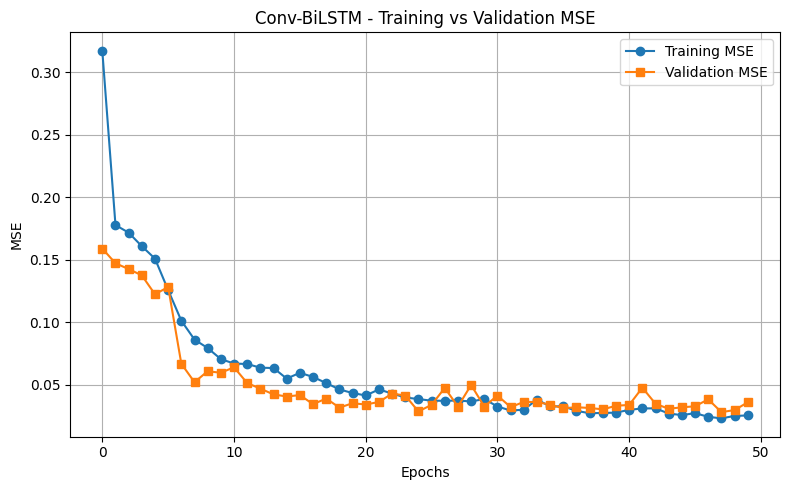

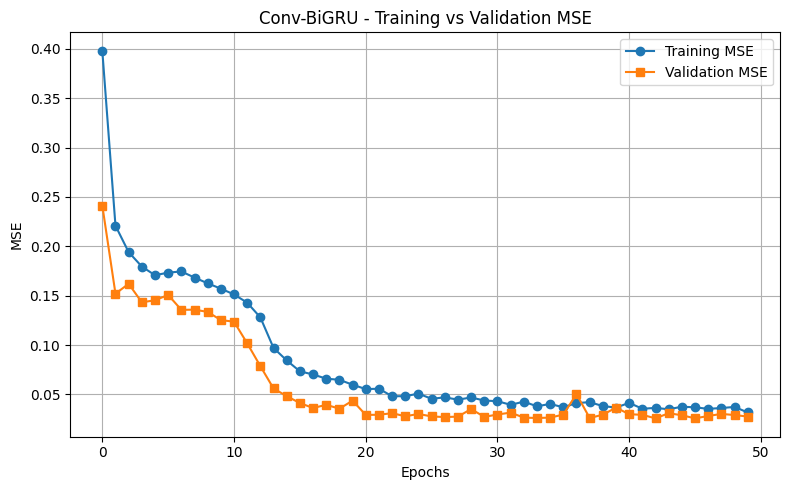

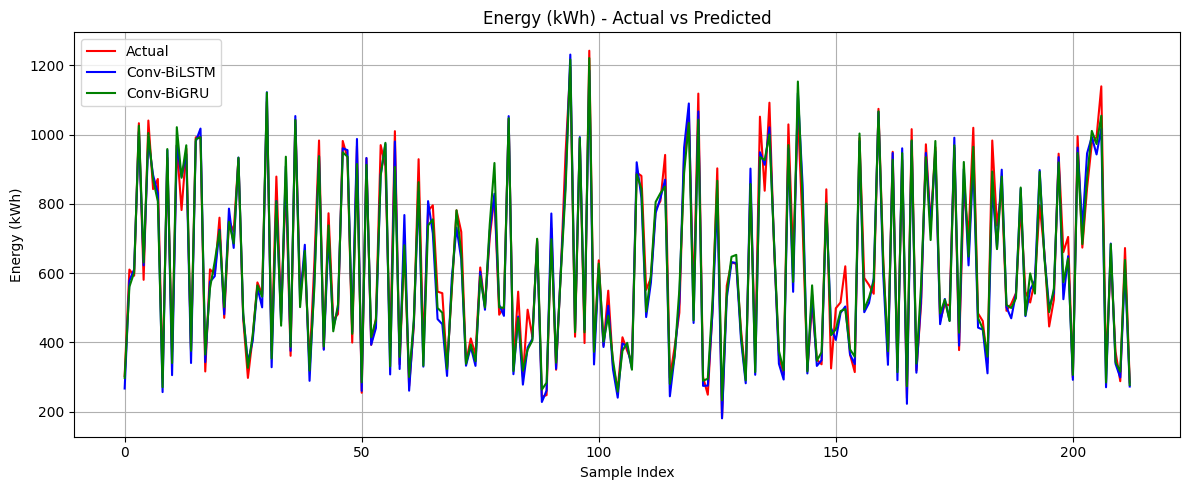

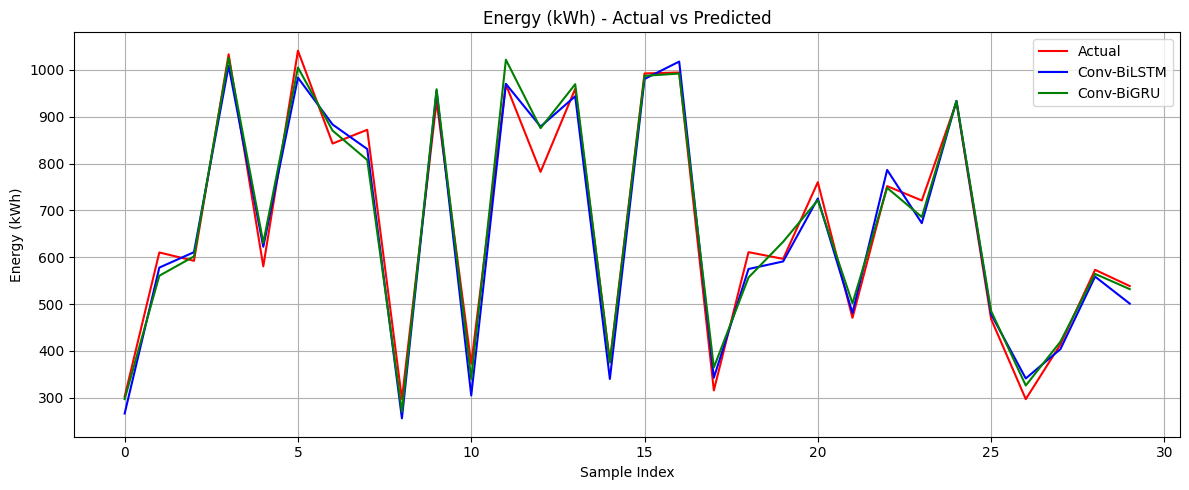

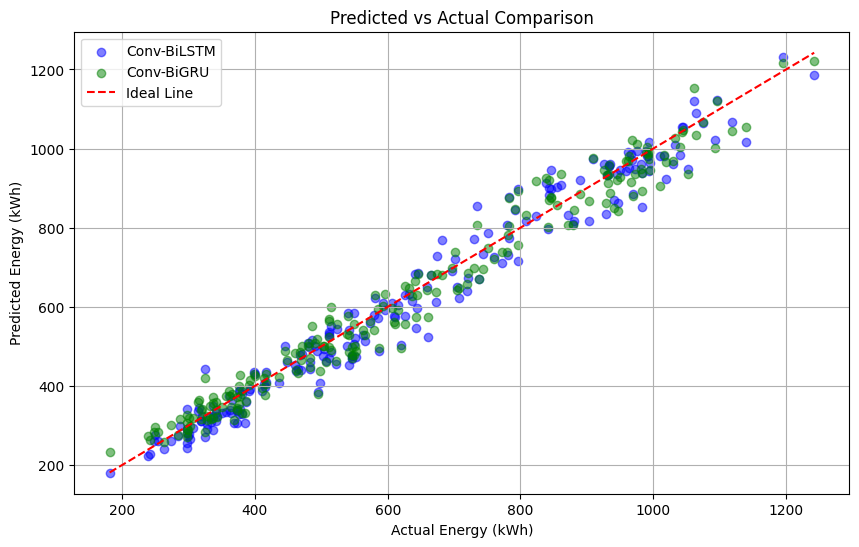

In [7]:
import pandas as pd
import numpy as np
import os
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed

# ✅ Load updated Perth dataset
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

# ✅ Updated feature engineering
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Total kWh'].shift(lag)
df['rolling_mean_3'] = df['Total kWh'].rolling(window=3).mean()
df['rolling_std_3'] = df['Total kWh'].rolling(window=3).std()
df['smooth_target'] = df['Total kWh'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# ✅ Updated columns
categorical_cols = ['CP ID', 'Connector', 'Site', 'Model', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Total_time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# ✅ Updated scaling
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# ✅ Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model_bilstm = build_model('lstm')
model_bigru = build_model('gru')

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title("Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters and GA for time steps selection

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

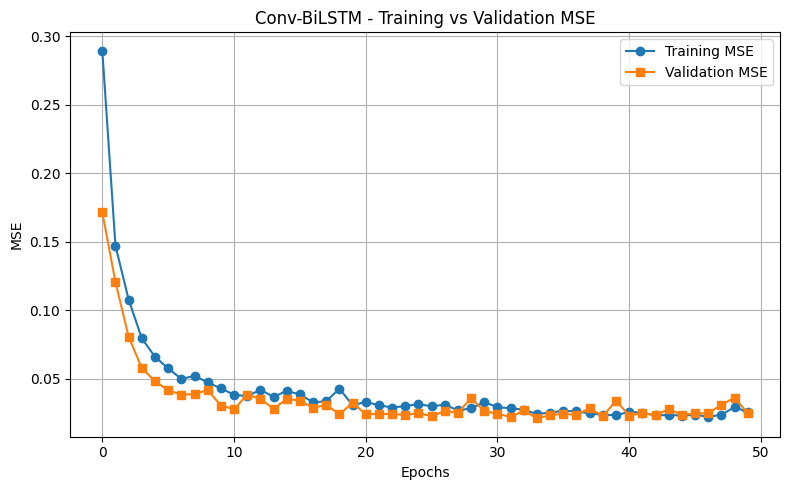

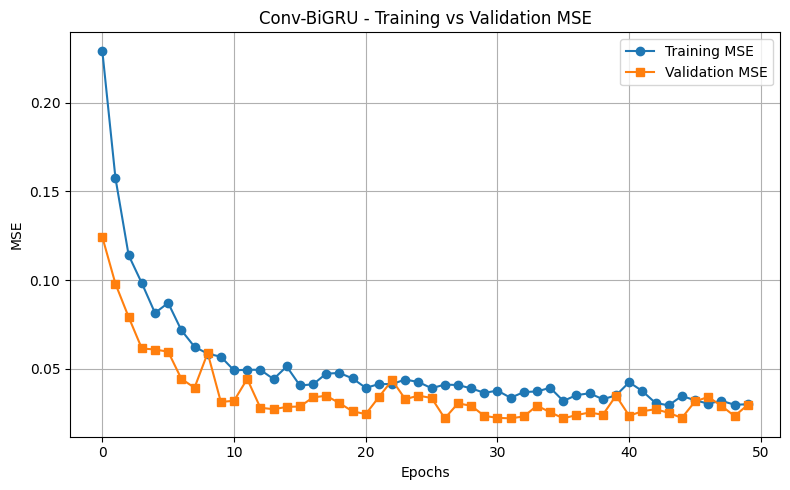

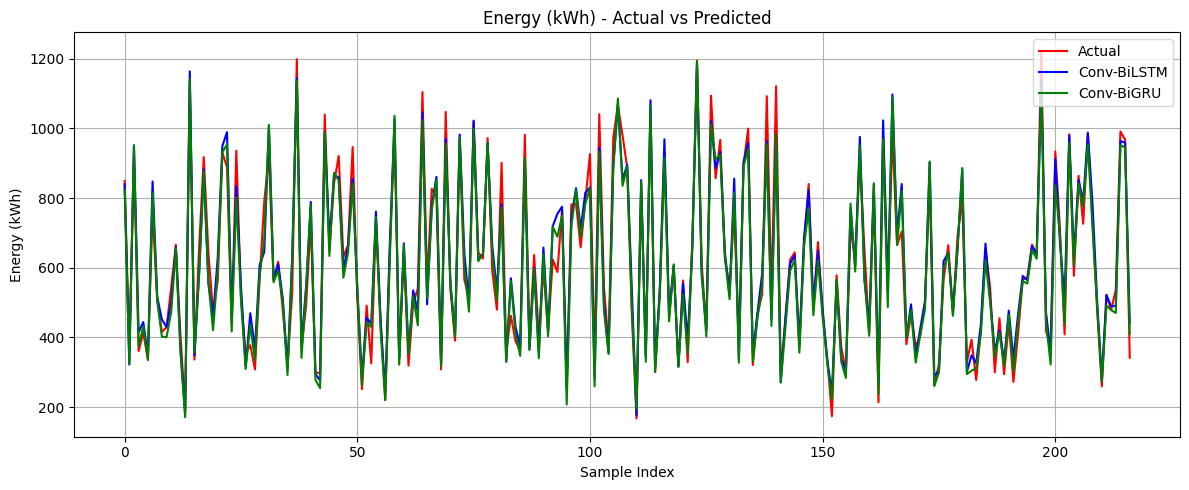

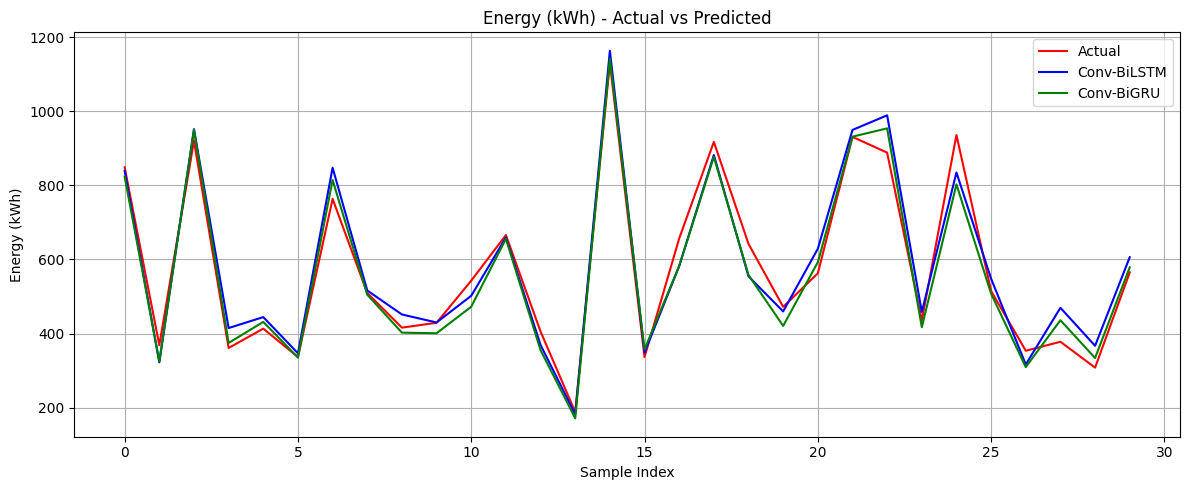

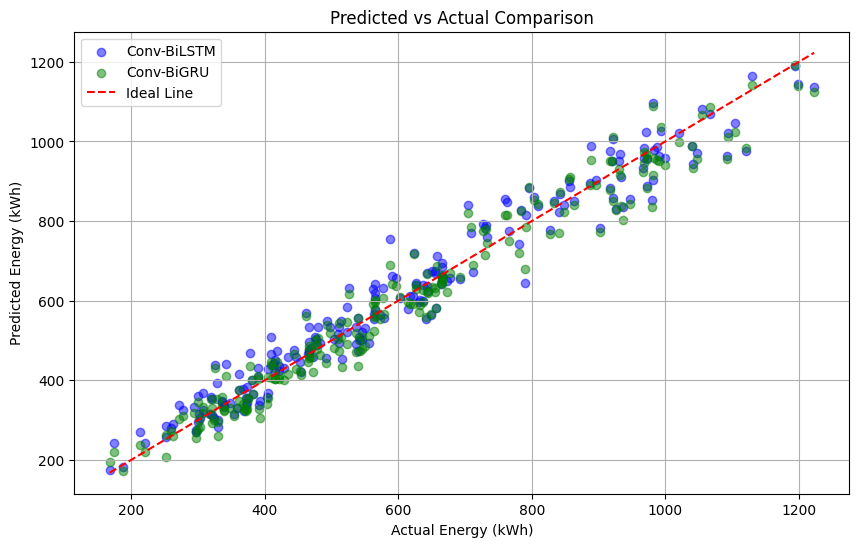

In [8]:
import pandas as pd
import numpy as np
import os
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import pygad

# ✅ Load Perth dataset
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

# ✅ Feature engineering
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Total kWh'].shift(lag)
df['rolling_mean_3'] = df['Total kWh'].rolling(window=3).mean()
df['rolling_std_3'] = df['Total kWh'].rolling(window=3).std()
df['smooth_target'] = df['Total kWh'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

categorical_cols = ['CP ID', 'Connector', 'Site', 'Model', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Total_time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

X_cat_full = df[categorical_cols].values
X_num_full = df[numerical_cols].values
y_full = df['target_scaled'].values

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type, time_steps):
    cat_inputs = [Input(shape=(time_steps,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(time_steps, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv = Conv1D(filters=128, kernel_size=1, activation='selu')(merged)

    if rnn_type == 'lstm':
        rnn = Bidirectional(LSTM(128, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111
    else:
        rnn = Bidirectional(GRU(80, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def create_sequences(X_cat, X_num, y, time_steps):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

# ✅ FITNESS FUNCTION
def fitness_func(ga_instance, solution, solution_idx):
    time_steps = int(solution[0])
    try:
        X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat_full, X_num_full, y_full, time_steps)
        X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
            X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

        train_inputs = prepare_input(X_cat_train, X_num_train)
        test_inputs = prepare_input(X_cat_test, X_num_test)

        model_bilstm = build_model('lstm', time_steps)
        model_bigru = build_model('gru', time_steps)

        model_bilstm.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
        model_bigru.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

        y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
        y_pred_bigru = model_bigru.predict(test_inputs).flatten()

        mse_bilstm = mean_squared_error(y_test, y_pred_bilstm)
        mse_bigru = mean_squared_error(y_test, y_pred_bigru)
        avg_mse = (mse_bilstm + mse_bigru) / 2

        return -avg_mse
    except Exception as e:
        print(f"Error at idx {solution_idx}: {e}")
        return 1e-3

ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=1,
    gene_type=int,
    init_range_low=7,
    init_range_high=90,
    gene_space={'low': 7, 'high': 90, 'step': 1},
    mutation_percent_genes=100,
    mutation_type="random"
)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_time_step = int(solution[0])
print(f"\n✅ BEST TIME STEP FOUND: {best_time_step} with fitness {solution_fitness:.6f}")

# ✅ FINAL TRAINING
X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat_full, X_num_full, y_full, best_time_step)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

model_bilstm = build_model('lstm', best_time_step)
model_bigru = build_model('gru', best_time_step)

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Peak Day Prediction using 7 day forecast

Epoch 1/110
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7341 
Epoch 1: val_loss improved from inf to 0.18141, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6881 - val_loss: 0.1814
Epoch 2/110
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1836
Epoch 2: val_loss improved from 0.18141 to 0.17512, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1833 - val_loss: 0.1751
Epoch 3/110
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1475
Epoch 3: val_loss improved from 0.17512 to 0.15982, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1487 - val_loss: 0.1598
Epoch 4/110
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1493
Epoch 4: val_loss improved from 0.15982 to 0.14371, saving model to temp_bilstm.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1489 - val_loss: 0.1437
Epoch 5/110
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1464
Epoch 5: val_loss improved from 0

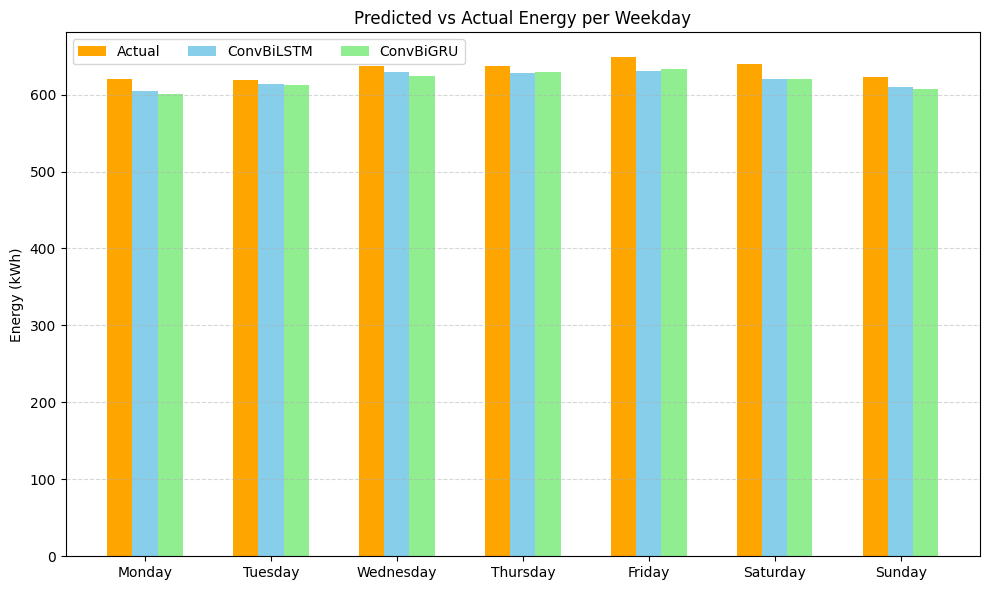

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
import os

# Load dataset
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Total kWh'].shift(lag)
df['rolling_mean_3'] = df['Total kWh'].rolling(window=3).mean()
df['rolling_std_3'] = df['Total kWh'].rolling(window=3).std()
df['smooth_target'] = df['Total kWh'].rolling(window=3, min_periods=1).mean()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['CP ID', 'Connector', 'Site', 'Model', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Total_time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']
target_col = 'smooth_target'

# Encode and scale
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Sequence data
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values
dow = df['Day_of_week'].values

def create_7day_sequences(X_cat, X_num, y, dow, time_steps=30):
    Xs_cat, Xs_num, ys, dows = [], [], [], []
    for i in range(len(X_cat) - time_steps - 7):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps:i + time_steps + 7])
        dows.append(dow[i + time_steps:i + time_steps + 7])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys), np.array(dows)

X_cat_seq, X_num_seq, y_seq, dow_seq = create_7day_sequences(X_cat, X_num, y, dow)

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, dow_train, dow_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, dow_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")
    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)
    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(7)(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Train Conv-BiLSTM
model_bilstm = build_model('lstm')
model_bilstm.fit(train_inputs, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Train Conv-BiGRU
model_bigru = build_model('gru')
model_bigru.fit(train_inputs, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")


# Predict
y_pred_bilstm_scaled = model_bilstm.predict(test_inputs)
y_pred_bigru_scaled = model_bigru.predict(test_inputs)

# Inverse transform predictions
def inverse_transform_7day(predictions):
    restored = []
    for i in range(predictions.shape[1]):
        pad = np.zeros((len(predictions), len(numerical_cols)))
        combined = np.hstack((pad, predictions[:, i:i+1]))
        restored_kwh = scaler.inverse_transform(combined)[:, -1]
        restored.append(restored_kwh)
    return np.stack(restored, axis=1)

y_pred_bilstm_kwh = inverse_transform_7day(y_pred_bilstm_scaled)
y_pred_bigru_kwh = inverse_transform_7day(y_pred_bigru_scaled)

# Aggregate predicted energy by weekday
weekday_energy_bilstm = {i: [] for i in range(7)}
weekday_energy_bigru = {i: [] for i in range(7)}

for i in range(len(dow_test)):
    for d, e1, e2 in zip(dow_test[i], y_pred_bilstm_kwh[i], y_pred_bigru_kwh[i]):
        weekday_energy_bilstm[d].append(e1)
        weekday_energy_bigru[d].append(e2)

# Calculate average and total energy
avg_kwh_bilstm = {d: np.mean(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
avg_kwh_bigru = {d: np.mean(weekday_energy_bigru[d]) for d in weekday_energy_bigru}
total_kwh_bilstm = {d: np.sum(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
total_kwh_bigru = {d: np.sum(weekday_energy_bigru[d]) for d in weekday_energy_bigru}

# Calculate actual average energy per weekday (from the original dataset)
def inverse_transform_actual(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    restored_kwh = scaler.inverse_transform(combined)[:, -1]
    return restored_kwh

df['Actual_Energy'] = inverse_transform_actual(df[target_col].values)

# Now, calculate the average energy per weekday
actual_avg_kwh = {i: np.mean(df[df['Day_of_week'] == i]['Actual_Energy']) for i in range(7)}

# Create readable DataFrame with actual values
df_summary = pd.DataFrame({
    'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'Avg_kWh_BiLSTM': [avg_kwh_bilstm[i] for i in range(7)],
    'Avg_kWh_BiGRU': [avg_kwh_bigru[i] for i in range(7)],
    'Actual_Avg_kWh': [actual_avg_kwh[i] for i in range(7)],
    'Total_kWh_BiLSTM': [total_kwh_bilstm[i] for i in range(7)],
    'Total_kWh_BiGRU': [total_kwh_bigru[i] for i in range(7)]
    
})

print("\n📋 Predicted and Actual Energy Summary per Weekday:")
print(df_summary)

# Optional: plot side-by-side average with actual energy values
plt.figure(figsize=(10, 6))
x = np.arange(7)
bar_width = 0.2
plt.bar(x - bar_width, df_summary['Actual_Avg_kWh'], width=bar_width, label='Actual', color='orange')
plt.bar(x, df_summary['Avg_kWh_BiLSTM'], width=bar_width, label='ConvBiLSTM', color='skyblue')
plt.bar(x + bar_width, df_summary['Avg_kWh_BiGRU'], width=bar_width, label='ConvBiGRU', color='lightgreen')
plt.xticks(x, df_summary['Weekday'])
plt.ylabel("Energy (kWh)")
plt.title("Predicted vs Actual Energy per Weekday")
plt.legend(loc='upper left', ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


ConvLSTM-BiLSTM encoder decoder

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 3.9577 - mae: 0.8037 - val_loss: 2.6136 - val_mae: 0.5811
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.4675 - mae: 0.5633 - val_loss: 1.9301 - val_mae: 0.4763
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8542 - mae: 0.4850 - val_loss: 1.5452 - val_mae: 0.4753
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4785 - mae: 0.4615 - val_loss: 1.3055 - val_mae: 0.4553
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2479 - mae: 0.4382 - val_loss: 1.1598 - val_mae: 0.4482
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.1125 - mae: 0.4364 - val_loss: 1.0483 - val_mae: 0.4438
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.0174 - mae: 0.4304 - val_loss: 0.9829 - val_mae: 0.4441
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.9575 - mae: 0.4265 - val_loss: 0.9355 - val_mae: 0.4394
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.88

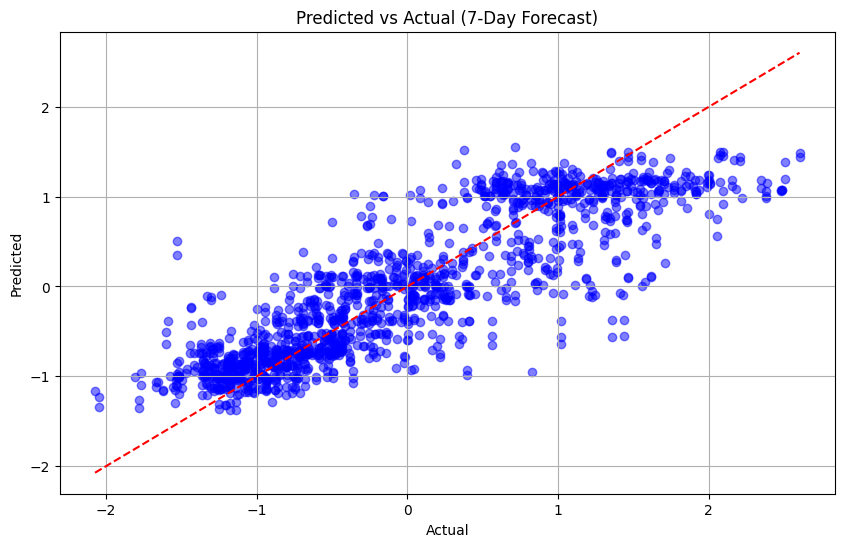

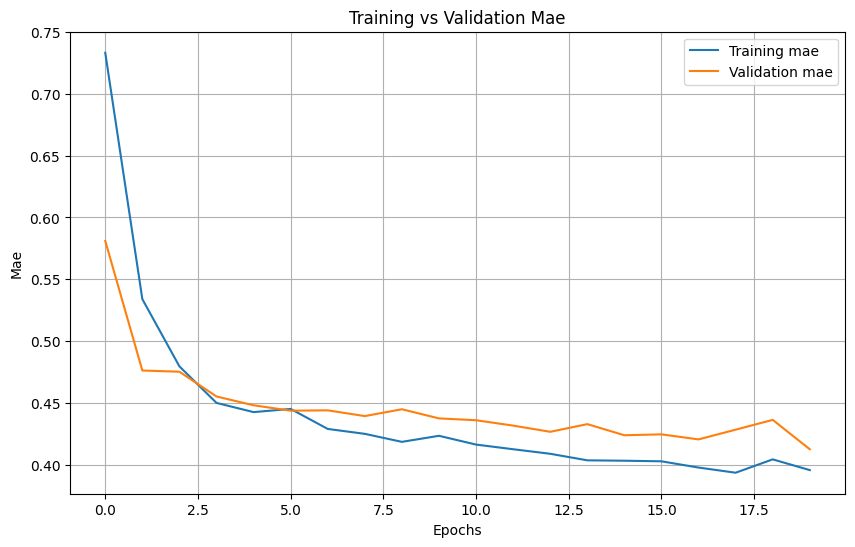

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Step 1: Load CSV
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Total kWh'])
target = df['Total kWh']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # shape = (time, rows=1, cols=n_features, channels=1)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build ConvLSTM → BiLSTM Model
def build_conv_bilstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False)(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_conv_bilstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Predict and Reshape Output
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)
y_true = y_test

# 11. Evaluation Metrics
def evaluate_model(y_true, y_pred, name="ConvLSTM-BiLSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance (7-Day Forecast):")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_true, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='blue')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


ConvBiLSTM-LSTM encoder decoder

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 2.0256 - mae: 0.8104 - val_loss: 1.5173 - val_mae: 0.7455
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3823 - mae: 0.6880 - val_loss: 1.1447 - val_mae: 0.6218
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.0023 - mae: 0.5661 - val_loss: 0.8900 - val_mae: 0.5609
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.8025 - mae: 0.5237 - val_loss: 0.7562 - val_mae: 0.5254
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.6735 - mae: 0.4781 - val_loss: 0.6503 - val_mae: 0.4836
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.5755 - mae: 0.4412 - val_loss: 0.5542 - val_mae: 0.4430
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.5233 - mae: 0.4273 - val_loss: 0.5144 - val_mae: 0.4338
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4689 - mae: 0.4045 - val_loss: 0.4669 - val_mae: 0.4101
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.45

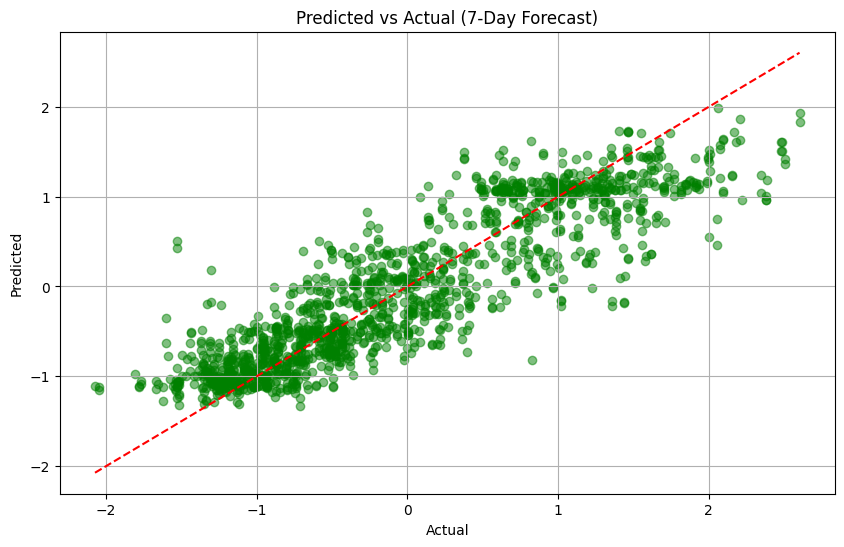

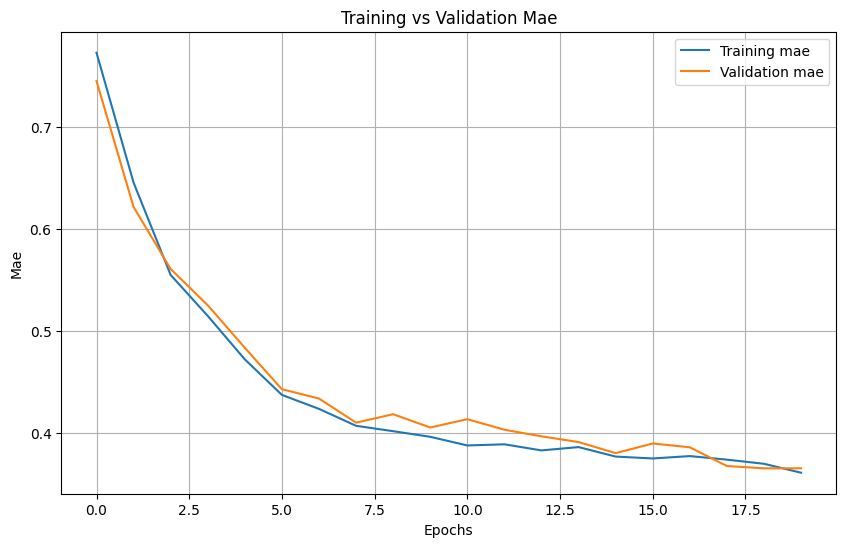

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Step 1: Load CSV
df = pd.read_csv("Perth_Resampled_withSeaWeekend.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Total kWh'])
target = df['Total kWh']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # (t, rows, cols, ch)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build BiConvLSTM → LSTM Model
def build_biconvlstm_lstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False))(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_biconvlstm_lstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Prediction
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)

# 11. Evaluation
def evaluate_model(y_true, y_pred, name="BiConvLSTM-LSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_test, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='green')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


C:\Users\user\AppData\Local\Temp\ipykernel_24788\2393805241.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.rename(columns={'Total_time_hours': 'Charge_time', 'Total kWh': 'Energy'}, inplace=True)


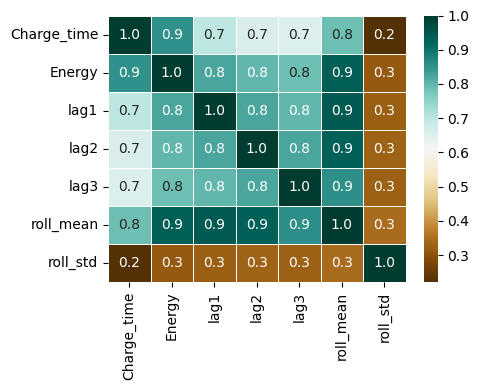

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Perth_Resampled_withSeaWeekend.csv')

# Ensure the data is sorted by date if necessary
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')

# Create lag features
df['lag1'] = df['Total kWh'].shift(1)
df['lag2'] = df['Total kWh'].shift(2)
df['lag3'] = df['Total kWh'].shift(3)

# Create rolling features (window=3, center=False)
df['roll_mean'] = df['Total kWh'].rolling(window=3).mean()
df['roll_std'] = df['Total kWh'].rolling(window=3).std()

# Select relevant columns
selected_columns = [
    'Total_time_hours', 'Total kWh',
    'lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std'
]
selected_df = df[selected_columns]
selected_df.rename(columns={'Total_time_hours': 'Charge_time', 'Total kWh': 'Energy'}, inplace=True)

# Drop rows with NaN from lag/rolling calculation
selected_df = selected_df.dropna()

# Compute correlation matrix
correlation_matrix = selected_df.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='BrBG', linewidths=0.5)
#plt.title('Correlation Heatmap: Perth')
plt.tight_layout()
plt.show()
